<a href="https://colab.research.google.com/github/VTNay/MEC557-Project/blob/Ma/MEC557_Weather_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projects

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2Fprojects.ipynb)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<div class="alert alert-block alert-warning">
    <b>Schedule</b>
    
- Ask your supervisors for the data if not already provided (it is not included in this repository).
- Quick presentation.
- Final project presentation.
    
</div>

<div class="alert alert-block alert-info">
    <b>One problematic, One dataset, One (or more) method(s)</b>
    
- Quality of the dataset is key.
- Results on a clean notebook.
- Explain which method(s) you used and why.
- If a method fails, explain why.

</div>

## Project: Weather station

<img alt="weather" src="https://github.com/VTNay/MEC557-Project/blob/main/images/map.png?raw=1" width=400>

- Suppose there are 5 weather stations that monitor the weather: Paris, Brest, London, Marseille and Berlin.
- The weather station in Paris breaks down
- Can we use the other stations to infer the weather in Paris

### Data set

<img alt="weather" src="https://github.com/VTNay/MEC557-Project/blob/main/images/annual_temperature.png?raw=1" width=400>

- Surface variables: skt, u10, v10, t2m, d2m, tcc, sp, tp, ssrd, blh
- Temporal resolution: hourly
- Spatial resolution: N/A

### First steps

- Look at the correlations between variables.
- What variable do I want to predict
- What time scale am interested in?
- Start with the easy predictions and move on to harder ones
- Are there events that are more predictable than others?

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
from functools import reduce
from matplotlib import pyplot as plt
from sklearn import preprocessing

paris_path = Path('/content/drive/My Drive/PHY557_Project/weather/paris')
brest_path = Path('/content/drive/My Drive/PHY557_Project/weather/brest')
london_path = Path('/content/drive/My Drive/PHY557_Project/weather/london')
marseille_path = Path('/content/drive/My Drive/PHY557_Project/weather/marseille')
berlin_path = Path('/content/drive/My Drive/PHY557_Project/weather/berlin')

file_path = {'t2m': 't2m.nc', 'blh': 'blh.nc', 'd2m': 'd2m.nc', 'skt': 'skt.nc', 'sp': 'sp.nc', 'ssrd': 'ssrd.nc', 'tcc': 'tcc.nc', 'tp': 'tp.nc', 'u10': 'u10.nc', 'v10': 'v10.nc'}
City_path = {'Paris': paris_path, 'Brest': brest_path, 'London': london_path, 'Marseille': marseille_path, 'Berlin': berlin_path}

Weather_stations = {'Paris': [], 'Brest': [], 'London': [], 'Marseille': [], 'Berlin': []}
for i in Weather_stations:
  Weather_stations[i] = {'t2m': [], 'blh': [], 'd2m': [], 'skt': [], 'sp': [], 'ssrd': [], 'tcc': [], 'tp': [], 'u10': [], 'v10': []}

for city in Weather_stations:
  for i in Weather_stations[city]:
    temp = xr.open_dataset(Path(City_path[city], file_path[i]))
    temp = temp.to_dataframe()
    if i == 'd2m' or i == 'blh':
      temp = temp.droplevel([1,2])
    else:
      temp = temp.droplevel([0,1])
    Weather_stations[city][i] = temp
  #merge them into 1 dataframe
  Weather_stations[city] = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), Weather_stations[city].values())

In [3]:
Berlin = Weather_stations['Berlin']
Brest =  Weather_stations['Brest']
London = Weather_stations['London']
Paris = Weather_stations['Paris']
Marseille = Weather_stations['Marseille']
Paris = Paris[Paris.index < '2020-01-01 07:00:00'] #All dataframe has the same number of rows

In [4]:
# Function to rename columns
def rename_columns(df, prefix):
    return df.rename(columns={col: f"{prefix}_{col}" for col in df.columns})
# Rename columns of each DataFrame so that the feature in X will be 'Berlin_t2m', 'Berlin_u10', 'London_t2m',...
Berlin = rename_columns(Berlin, 'Berlin')
Brest = rename_columns(Brest, 'Brest')
London = rename_columns(London, 'London')
Marseille = rename_columns(Marseille, 'Marseille')

In [5]:
#Data cleaning
# Concatenate X = Berlin, Brest, London, Marseille and y = Paris
combined = pd.concat([Berlin, Brest, London, Marseille, Paris], axis=1)
# Drop NA values
combined = combined.dropna()
# Split them back into X and y
X_raw = combined.iloc[:, :-10]  # X has 40 features
y = combined.loc[:,'t2m']  # y is the temperature in Paris
# Normalize X and y
X_raw = (X_raw - X_raw.mean())/ X_raw.std()
y = (y - y.mean())/y.std()
# Number of years
n_years = y.index.year.max() - y.index.year.min() + 1
n_years

40

**PCA**

Lasso is a linear model that uses this cost function:

$$
\frac{1}{2N_{\text{training}}} \sum_{i=1}^{N_{\text{training}}} \left( y^{(i)}_{\text{real}} - y^{(i)}_{\text{pred}} \right)^2 + \alpha \sum_{j=1}^{n} |a_j|
$$

$a_j$ is the coefficient of the j-th feature. The final term is called $l_1$ penalty and $\alpha$ is a hyperparameter that tunes the intensity of this penalty term. The higher the coefficient of a feature, the higher the value of the cost function. So, the idea of Lasso regression is to optimize the cost function reducing the absolute values of the coefficients.


In [6]:
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
# Number of features remained
n_features = 20

# Set number of splits for cross-validation - two years for each fold
n_splits =  5 # We have 40 years in total

# Initialize LassoCV, which will perform cross-validation
lasso = LassoCV(cv=n_splits, random_state=0, max_iter=10000)

# Fit the Lasso model to the data
lasso.fit(X_raw, y)

# n_features features having the highest absolute value of coefficient can be considered as more important or keeped
indices_top = np.argsort(np.abs(lasso.coef_))[-n_features:]
selected_features = [X_raw.columns[i] for i in indices_top]

# To reduce the feature set
X = X_raw[selected_features]

## Fucntion ##

This cell of code is to define a function ${poly\_ridge}$ whose input will be:
- degree: the degree of the polynomial fitting;
- n_splits_cv: the number of set which is split for cross validation;
-

In [7]:
from inspect import modulesbyfile
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
#Linear Regression for Paris_t2m with 40 features - the most naive approach
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
#Ridge
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

def poly_ridge(degree, n_splits_cv, X_cv, y_cv, alphas):
  # Declare empty arrays in which to store r2 scores and coefficients
  r2_validation = np.empty(alphas.shape)

  # Loop over regularization-parameter values
  for k, complexity in enumerate(alphas):
      # Transform data to include polynomial features
      polynomial_features = PolynomialFeatures(degree=degree, include_bias=True)
      # Define the Ridge estimator for particular regularization-parameter value
      reg = Ridge(alpha=complexity)
      # Create a pipeline that includes both polynomial expansion and ridge regression
      model = make_pipeline(polynomial_features, reg)
      # Get r2 test scores from k-fold cross-validation
      r2_validation_arr = cross_val_score(model, X_cv, y_cv, cv=n_splits_cv)

      # Get r2 expected prediction score by averaging over test scores
      r2_validation[k] = r2_validation_arr.mean()

  # Get the best values of the regularization parameter, prediction R2 and coefficients
  i_best = np.argmax(r2_validation)
  alpha_best = alphas[i_best]
  r2_validation_best = r2_validation[i_best]
  return r2_validation, i_best


In [17]:
# Degree 1 with full number of features
degree = 1
X_raw_cv, X_raw_test, y_cv, y_test = train_test_split(X_raw, y, test_size=.25, random_state=0)
n_split_cv = 5
alphas = np.logspace(-3, 1, 100)
r2_validation, i_best = poly_ridge(degree, n_split_cv, X_raw_cv, y_cv, alphas)
# Transform data to include polynomial features
polynomial_features = PolynomialFeatures(degree=degree, include_bias=True)
# Define the Ridge estimator for particular regularization-parameter value
reg = Ridge(alpha=alphas[i_best])
# Create a pipeline that includes both polynomial expansion and ridge regression
best_model = make_pipeline(polynomial_features, reg)

best_model.fit(X_raw_cv, y_cv)
R2 = best_model.score(X_raw_test, y_test)

0.4229242874389499


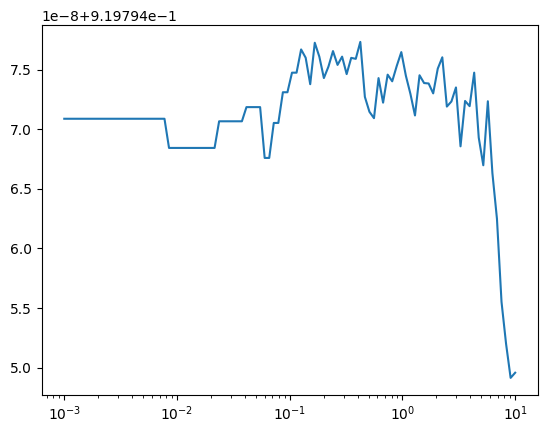

In [19]:
plt.plot(alphas, r2_validation)
plt.xscale('log')
print(alphas[i_best])

In [ ]:
# Degree 1 with reduced number (20) of features
degree = 1
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=.25, random_state=0)
n_split_cv = 5
alphas = np.logspace(-3, 1, 50)
r2_validation, i_best = poly_ridge(degree, n_split_cv, X_cv, y_cv, alphas)
# Transform data to include polynomial features
polynomial_features = PolynomialFeatures(degree=degree, include_bias=True)
# Define the Ridge estimator for particular regularization-parameter value
reg = Ridge(alpha=alphas[i_best])
# Create a pipeline that includes both polynomial expansion and ridge regression
best_model = make_pipeline(polynomial_features, reg)
best_model.fit(X_cv, y_cv)
R2 = best_model.score(X_test, y_test)

0.2329951810515372


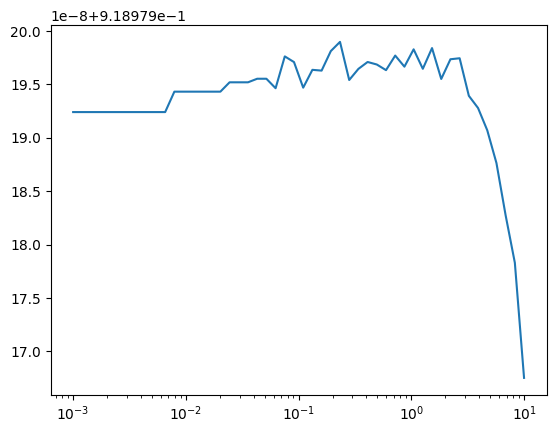

In [16]:
plt.plot(alphas, r2_validation)
plt.xscale('log')
print(alphas[i_best])

In [8]:
# Degree 2 with reduced number (20) of features
degree = 2
n_split_cv = 5
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=.25, random_state=0)
alphas = np.logspace(-3, 1, 50)
r2_validation, i_best = poly_ridge(degree, n_split_cv, X_cv, y_cv, alphas)
# Transform data to include polynomial features
polynomial_features = PolynomialFeatures(degree=degree, include_bias=True)
# Define the Ridge estimator for particular regularization-parameter value
reg = Ridge(alpha=alphas[i_best])
# Create a pipeline that includes both polynomial expansion and ridge regression
best_model = make_pipeline(polynomial_features, reg)
best_model.fit(X_cv, y_cv)
R2 = best_model.score(X_test, y_test)


1.2648552168552958


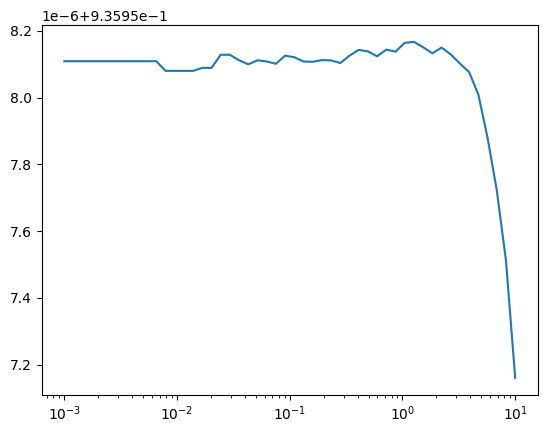

In [9]:
plt.plot(alphas, r2_validation)
plt.xscale('log')
print(alphas[i_best])

In [ ]:
# Degree 3 with reduced number (20) of features
degree = 3
n_split_cv = 5
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=.25, random_state=0)
alphas = np.logspace(-3, 1, 50)
r2_validation, i_best = poly_ridge(degree, n_split_cv, X_cv, y_cv, alphas)
# Transform data to include polynomial features
polynomial_features = PolynomialFeatures(degree=degree, include_bias=True)
# Define the Ridge estimator for particular regularization-parameter value
reg = Ridge(alpha=alphas[i_best])
# Create a pipeline that includes both polynomial expansion and ridge regression
best_model = make_pipeline(polynomial_features, reg)
best_model.fit(X_cv, y_cv)
R2 = best_model.score(X_test, y_test)
print(r2_validation)
print(R2)

In [ ]:
plt.plot(alphas, r2_validation)
plt.xscale('log')
print(alphas[i_best])

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_lmd.jpg?raw=1" style="display: inline-block"/>

<img alt="Logo IPSL" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_ipsl.png?raw=1" style="display: inline-block"/>

<img alt="Logo E4C" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_e4c_final.png?raw=1" style="display: inline-block"/>

<img alt="Logo EP" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_ep.png?raw=1" style="display: inline-block"/>

<img alt="Logo SU" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_su.png?raw=1" style="display: inline-block"/>

<img alt="Logo ENS" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_ens.jpg?raw=1" style="display: inline-block"/>

<img alt="Logo CNRS" src="https://github.com/VTNay/MEC557-Project/blob/main/images/logos/logo_cnrs.png?raw=1" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>